In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

sns.set()

In [3]:
building = cv2.imread('seg_train/seg_train/buildings/10006.jpg')
building.shape

(150, 150, 3)

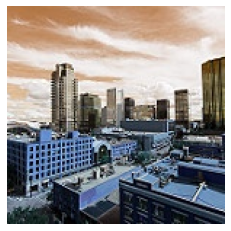

In [5]:
plt.imshow(building)
plt.axis('off');

In [ ]:
import os

class_folder_paths = ['seg_train/seg_train/' + x for x in os.listdir('seg_train/seg_train/')]

In [ ]:
class_folder_paths

['seg_train/seg_train/forest',
 'seg_train/seg_train/sea',
 'seg_train/seg_train/glacier',
 'seg_train/seg_train/mountain',
 'seg_train/seg_train/street',
 'seg_train/seg_train/buildings']

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(horizontal_flip=True)

train_gen = train_data_gen.flow_from_directory('/content/seg_train/seg_train',
                                               target_size=(150, 150),
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True)

val_data_gen = ImageDataGenerator()
val_gen = val_data_gen.flow_from_directory('/content/seg_test/seg_test',
                                           target_size=(150, 150),
                                           color_mode='rgb',
                                           batch_size=32,
                                           class_mode='categorical',
                                           shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense

bm = Sequential([Input((150, 150, 3)),
                 Lambda(preprocess_input)])

m = MobileNetV2(input_shape=(150, 150, 3), include_top=False)

am = Sequential([GlobalAveragePooling2D(),
                 Dropout(0.3),
                 Dense(6, activation='softmax')])

model = Sequential([bm, m, am])

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.build((None, 150, 150, 3)) 

In [14]:
bm.summary()
m.summary()
am.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 150, 150, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         

In [34]:
!zip -r model.zip model/ 

	zip warning: name not matched: model/

zip error: Nothing to do! (try: zip -r model.zip . -i model/)


In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


train_cb = ModelCheckpoint('model/', save_best_only=True)

early_stop = EarlyStopping(patience=3, monitor='loss') 

model.fit(train_gen, validation_data=val_gen, callbacks=[early_stop, train_cb], epochs=100)

Epoch 1/100
  2/439 [..............................] - ETA: 38:36 - loss: 0.2731 - accuracy: 0.9531

KeyboardInterrupt: ignored